<h1 style="text-align:center">Multiple Linear Regression using Stochastic Gradient Descent vs Least Squares Method</h1>
<h3 style="text-align:center">By Charles Chinedu Nworu</h3>

<h2>Introduction</h2>
<p style="font-family:'Times New Roman';font-size: 16px;text-align: justify"> In this article, we're going to compare the predictive power of the stochastic gradient descent (sgd) and the ordinary regression equation (ols). I implemented the sgd in pytorch while the ols with scikit-learn.</p>

<h3>Import libraries</h3>

In [91]:
import numpy as np # linear algebra
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

#pytorch libraries
import torch
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F

#scikit libraries
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")

<h3>Loading data</h3>
<p style="font-family:'Times New Roman';font-size: 16px;text-align: justify">The dataset is the Boston housing data which can be found in Kaggle respository.</p>

In [92]:
column_names = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']
data = pd.read_csv("housing.csv", header=None, delimiter=r"\s+", names=column_names)
data.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


<h3>Dimension of the dataset</h3>

In [93]:
print(np.shape(data))

(506, 14)


<h3>Data distribution and visualization</h3>

In [94]:
print(data.describe())

             CRIM          ZN       INDUS        CHAS         NOX          RM  \
count  506.000000  506.000000  506.000000  506.000000  506.000000  506.000000   
mean     3.613524   11.363636   11.136779    0.069170    0.554695    6.284634   
std      8.601545   23.322453    6.860353    0.253994    0.115878    0.702617   
min      0.006320    0.000000    0.460000    0.000000    0.385000    3.561000   
25%      0.082045    0.000000    5.190000    0.000000    0.449000    5.885500   
50%      0.256510    0.000000    9.690000    0.000000    0.538000    6.208500   
75%      3.677083   12.500000   18.100000    0.000000    0.624000    6.623500   
max     88.976200  100.000000   27.740000    1.000000    0.871000    8.780000   

              AGE         DIS         RAD         TAX     PTRATIO           B  \
count  506.000000  506.000000  506.000000  506.000000  506.000000  506.000000   
mean    68.574901    3.795043    9.549407  408.237154   18.455534  356.674032   
std     28.148861    2.1057

<h3>Data Preprocessing</h3>
<p style="font-family:'Times New Roman';font-size: 16px;text-align: justify">Check missing values</p>

In [95]:
print("Checking null values...")
print(data.isnull().sum())
print("----------------------------")
print()
print("Checking na values...")
print(data.isna().sum())
print()
print("Completed")

Checking null values...
CRIM       0
ZN         0
INDUS      0
CHAS       0
NOX        0
RM         0
AGE        0
DIS        0
RAD        0
TAX        0
PTRATIO    0
B          0
LSTAT      0
MEDV       0
dtype: int64
----------------------------

Checking na values...
CRIM       0
ZN         0
INDUS      0
CHAS       0
NOX        0
RM         0
AGE        0
DIS        0
RAD        0
TAX        0
PTRATIO    0
B          0
LSTAT      0
MEDV       0
dtype: int64

Completed


<p style="font-family:'Times New Roman';font-size: 16px;text-align: justify">From the above, we can observe that there's no missing value<p>

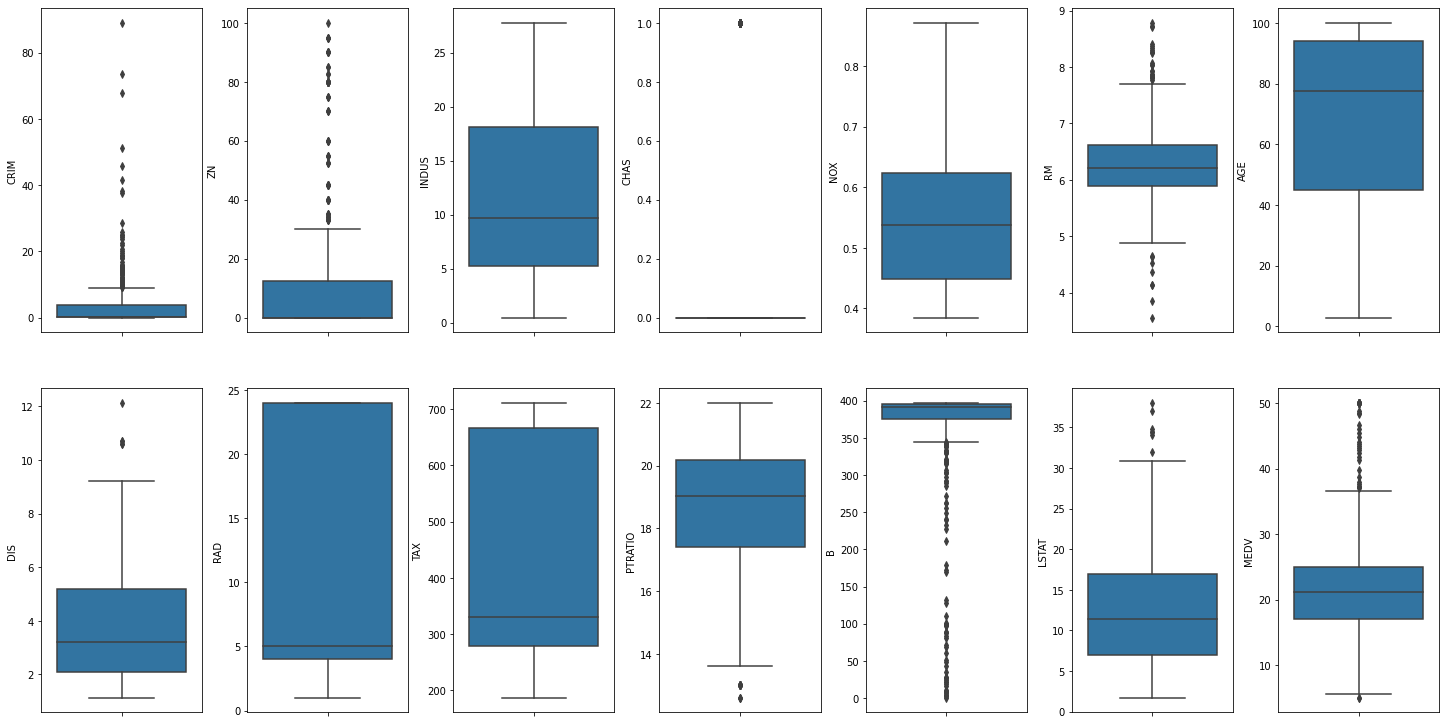

In [96]:
fig, axs = plt.subplots(ncols=7, nrows=2, figsize=(20, 10))
index = 0
axs = axs.flatten()
for k,v in data.items():
    sns.boxplot(y=k, data=data, ax=axs[index])
    index += 1
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)

<p style="font-family:'Times New Roman';font-size: 16px;text-align: justify">The boxplot shows varaibles with outliers</p>

In [98]:
 for k, v in data.items():
        q1 = v.quantile(0.25)
        q3 = v.quantile(0.75)
        irq = q3 - q1
        v_col = v[(v <= q1 - 1.5 * irq) | (v >= q3 + 1.5 * irq)]
        perc = np.shape(v_col)[0] * 100.0 / np.shape(data)[0]
        print("Column %s outliers = %.2f%%" % (k, perc))

Column CRIM outliers = 13.04%
Column ZN outliers = 13.44%
Column INDUS outliers = 0.00%
Column CHAS outliers = 100.00%
Column NOX outliers = 0.00%
Column RM outliers = 5.93%
Column AGE outliers = 0.00%
Column DIS outliers = 0.99%
Column RAD outliers = 0.00%
Column TAX outliers = 0.00%
Column PTRATIO outliers = 2.96%
Column B outliers = 15.22%
Column LSTAT outliers = 1.38%
Column MEDV outliers = 7.91%


<h3>Let's remove MEDV outliers (MEDV = 50.0) before plotting more distributions</h3>

In [99]:
data = data[~(data['MEDV'] >= 50.0)]
print(np.shape(data))

(490, 14)


<p style="font-family:'Times New Roman';font-size: 16px;text-align: justify">Let's remove instances with outliers more than 50%.</p>

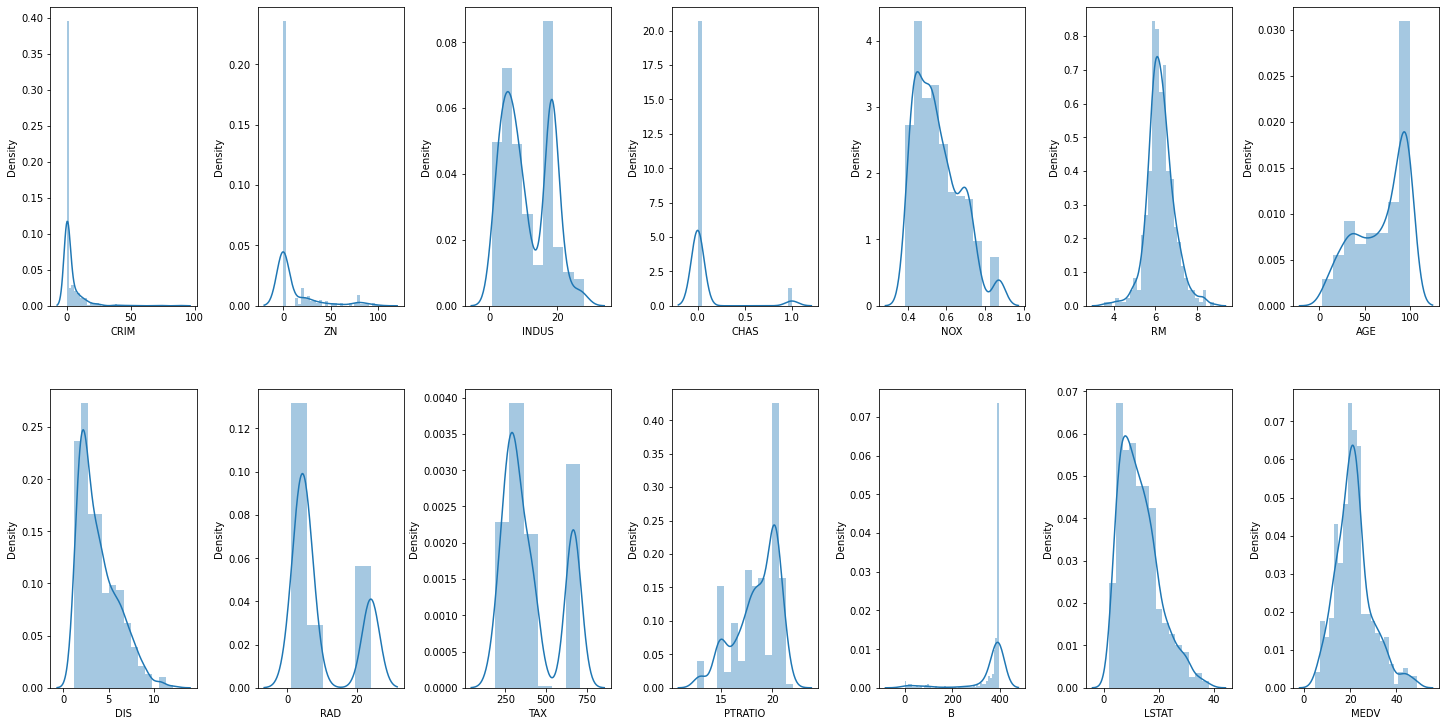

In [10]:
fig, axs = plt.subplots(ncols=7, nrows=2, figsize=(20, 10))
index = 0
axs = axs.flatten()
for k,v in data.items():
    sns.distplot(v, ax=axs[index])
    index += 1
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)

<p>The data looks skewed</p>

<p style="text-align:justify">From correlation matrix, we see TAX and RAD are highly correlated features. The columns LSTAT, INDUS, RM, TAX, NOX, PTRAIO has a correlation score above 0.5 with MEDV which is a good indication of using as predictors.</p>
<p>Let's plot these columns against MEDV.</p>

<AxesSubplot:>

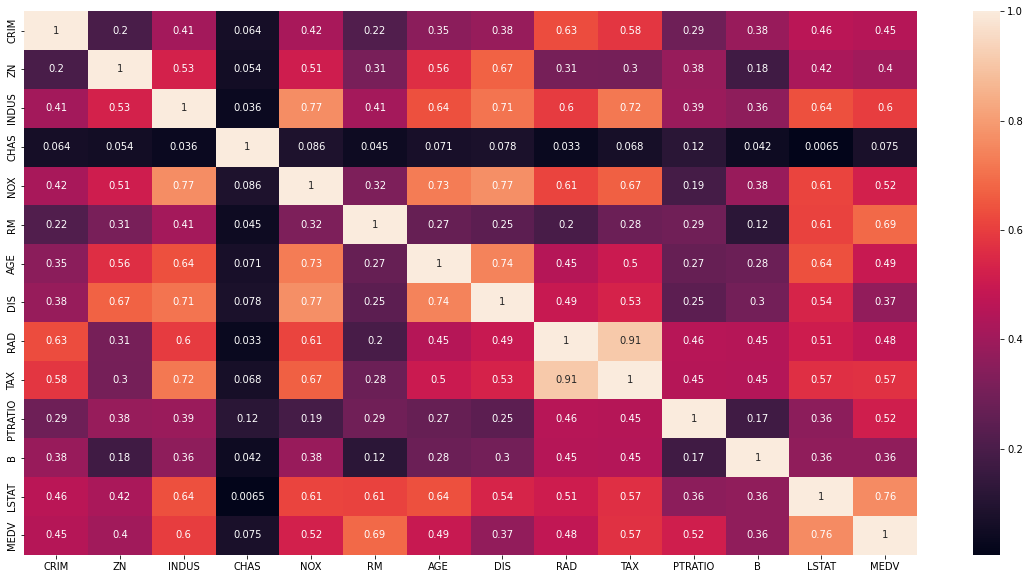

In [11]:
plt.figure(figsize=(20, 10))
sns.heatmap(data.corr().abs(),  annot=True)

<p style="text-align:justify">We're only going to work with independent varaibles that are correlated with the response variables.</p>

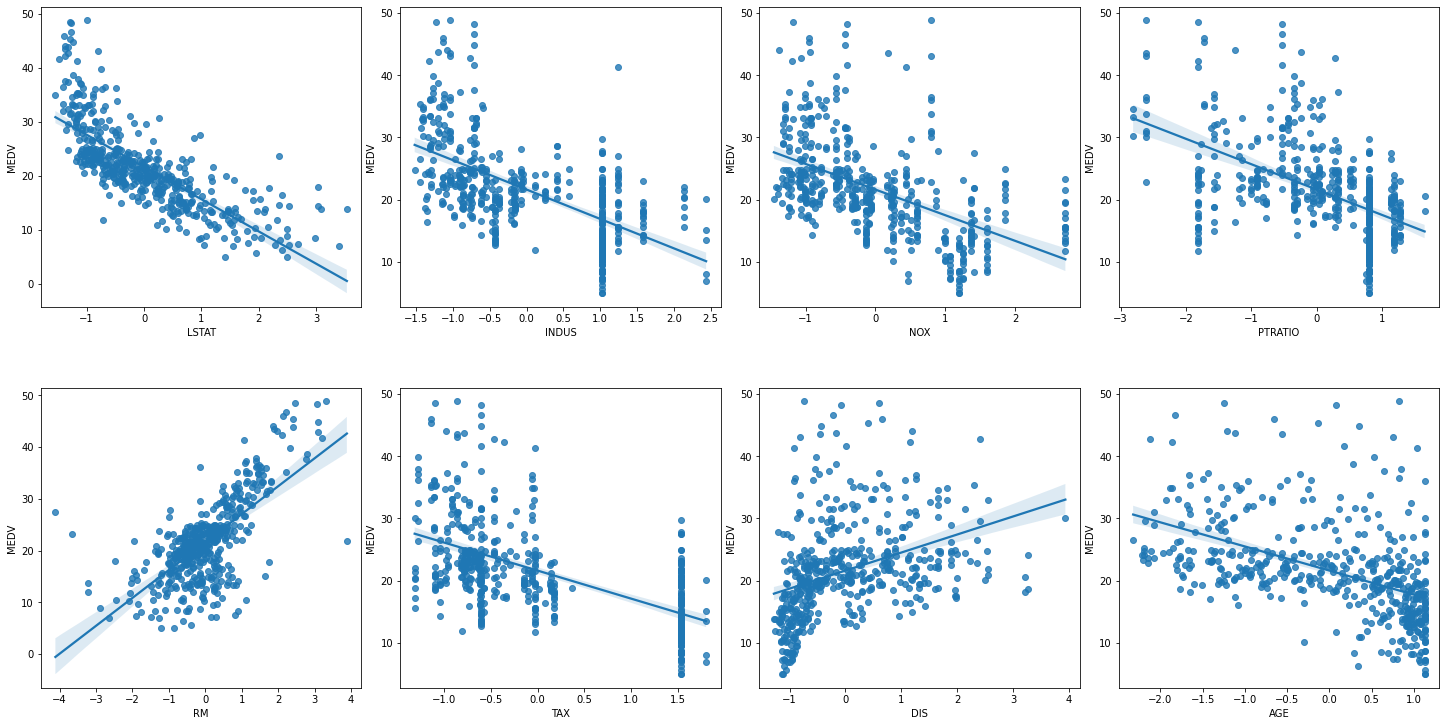

In [12]:
from sklearn import preprocessing
# Let's scale the columns before plotting them against MEDV
scaler = preprocessing.StandardScaler()
column_sels = ['LSTAT', 'INDUS', 'NOX', 'PTRATIO', 'RM', 'TAX', 'DIS', 'AGE']
x = data.loc[:,column_sels]
y = data['MEDV']
z = pd.DataFrame(data=scaler.fit_transform(x), columns=column_sels)
fig, axs = plt.subplots(ncols=4, nrows=2, figsize=(20, 10))
index = 0
axs = axs.flatten()
for i, k in enumerate(column_sels):
    sns.regplot(y=y, x=z[k], ax=axs[i])
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)

<h3>Split into training and test sets<h3>

In [101]:
# Select 20% for validation
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1)
print(X_train.shape, X_test.shape)

(392, 8) (98, 8)


<h1>Stochastic Gradient Descent</h1>
<h3>Model Building</h3>

In [102]:
# Train set
X_train = scaler.fit_transform(X_train)
X_train = torch.from_numpy(X_train.astype(np.float32))

# Test set
X_test = scaler.transform(X_test)
X_test = torch.from_numpy(X_test.astype(np.float32))

# Train target set
y_train = np.array(y_train).astype(np.float32)
y_train = torch.from_numpy(y_train)

# Tesr target set
y_test = np.array(y_test).astype(np.float32)
y_test = torch.from_numpy(y_test)

In [103]:
# Combine the independent variables and response variable 
train_ds = TensorDataset(X_train, y_train)

In [16]:
batch_size = 64
train_dl = DataLoader(train_ds, batch_size, shuffle = True)

In [104]:
# Define model
model = nn.Linear(8, 1)
print(model.weight)
print(model.bias)

Parameter containing:
tensor([[ 0.2995,  0.2122,  0.1318, -0.1507,  0.1756,  0.1305,  0.0599, -0.1321]],
       requires_grad=True)
Parameter containing:
tensor([-0.0586], requires_grad=True)


In [105]:
list(model.parameters())

[Parameter containing:
 tensor([[ 0.2995,  0.2122,  0.1318, -0.1507,  0.1756,  0.1305,  0.0599, -0.1321]],
        requires_grad=True),
 Parameter containing:
 tensor([-0.0586], requires_grad=True)]

In [109]:
preds = model(X_train)
preds[0:6]

tensor([[ 0.5961],
        [-0.5184],
        [ 0.5463],
        [-0.0852],
        [ 0.4624],
        [-0.0158]], grad_fn=<SliceBackward0>)

<p>The predicted values are just initial values</p>

## Loss function

In [112]:
loss_fn = F.mse_loss

loss = loss_fn(model(X_train), y_train)
print(loss)

tensor(533.4255, grad_fn=<MseLossBackward0>)


## Optimizer

In [113]:
learning_rate = 0.0005
opt = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [114]:
#Utility function to train the model

def fit(num_epochs, model, loss_fn, opt):
    # Repeat for given number of epochs
    losses = []
    for epoch in range(num_epochs):
        # Train with batches of data
        # start = time.time()
        for xb, yb in train_dl:
            #1. Generate predictions
            pred = model(xb)
            #2. Calculate loss
            loss = loss_fn(pred, yb)
            #3. compute gradients
            loss.backward()
            #4. update parameters
            opt.step()
            #5. reset the gradients to zero
            opt.zero_grad()
        # print the progress
        if (epoch+1)%10==0:
            losses.append(loss.item())
            print("Epoch [{}/{}], Loss: {:.4f}". format(epoch+1, num_epochs, loss.item()))
            #print(f'Time: {time.time() - start}')
            #print('----------------------------------------------')
    #print(losses)

In [115]:
fit(1000, model, loss_fn, opt)

Epoch [10/1000], Loss: 13981.0557
Epoch [20/1000], Loss: 13167.0645
Epoch [30/1000], Loss: 11417.4639
Epoch [40/1000], Loss: 9265.0518
Epoch [50/1000], Loss: 8011.7124
Epoch [60/1000], Loss: 7382.6006
Epoch [70/1000], Loss: 6966.8154
Epoch [80/1000], Loss: 5595.2334
Epoch [90/1000], Loss: 5323.0420
Epoch [100/1000], Loss: 4321.8975
Epoch [110/1000], Loss: 3511.0496
Epoch [120/1000], Loss: 3480.9512
Epoch [130/1000], Loss: 3307.2134
Epoch [140/1000], Loss: 2273.6885
Epoch [150/1000], Loss: 2164.0869
Epoch [160/1000], Loss: 1705.7660
Epoch [170/1000], Loss: 1898.5939
Epoch [180/1000], Loss: 1382.1338
Epoch [190/1000], Loss: 1492.5724
Epoch [200/1000], Loss: 1026.8066
Epoch [210/1000], Loss: 921.0096
Epoch [220/1000], Loss: 986.6267
Epoch [230/1000], Loss: 724.4362
Epoch [240/1000], Loss: 730.5087
Epoch [250/1000], Loss: 526.7578
Epoch [260/1000], Loss: 719.4896
Epoch [270/1000], Loss: 447.0771
Epoch [280/1000], Loss: 319.8055
Epoch [290/1000], Loss: 447.7789
Epoch [300/1000], Loss: 322.1

In [116]:
# Generate predictions
y_train_pred = model(X_train)
y_test_pred = model(X_test)

In [117]:
# make predictions on the testing set
loss_train = loss_fn(y_train_pred, y_train)
loss_test = loss_fn(y_test_pred, y_test)
print("Train MSE: {:.4f}".format(loss_train.item()))
print("Test MSE: {:.4f}".format(loss_test.item()))

Train MSE: 63.1690
Test MSE: 56.2756


<h1>Least Squares Method</h1>

In [118]:
# importing linear regression function
import sklearn.linear_model as lm
# Create linear regression object
lr = lm.LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [119]:
# make predictions on the testing set
y_train_pred_lr = lr.predict(X_train)
y_test_pred_lr = lr.predict(X_test)

In [120]:
y_train_pred_lr = np.array(y_train_pred_lr).astype(np.float32)
y_train_pred_lr = torch.from_numpy(y_train_pred_lr)
loss_train_lr = loss_fn(y_train_pred_lr, y_train)

y_test_pred_lr = np.array(y_test_pred_lr).astype(np.float32)
y_test_pred_lr = torch.from_numpy(y_test_pred_lr)
loss_test_lr = loss_fn(y_test_pred_lr, y_test)

print("Train MSE: {:.4f}".format(loss_train_lr))
print("Test MSE: {:.4f}".format(loss_test_lr))

Train MSE: 15.0466
Test MSE: 16.4870


<h3>Tabulate MSE vales for the different methods for both train and test sets</h3>

In [140]:
errors = {"Train MSE": [loss_train_lr.item(), loss_train.item()], "Test MSE": [loss_test_lr.item(), loss_test.item()]}
df_1 = pd.DataFrame(errors, index=['lr', 'sgd'])
df_1

,Train MSE,Test MSE
lr,15.046576,16.486952
sgd,63.169044,56.275597


<p style="font-family:'Times New Roman';font-size: 16px;text-align: justify">From the table, we observe that the linear regression performs better than the stochastic gradient descent</p>

<h3>Combine predictions for the different methods</h3>

In [123]:
predictions = {"response": y_test, "pred_lr": y_test_pred_lr, "pred_sgd" : y_test_pred.detach().numpy().flatten()}
df_2 = pd.DataFrame(predictions)
df_2

,response,pred_lr,pred_sgd
0,21.900000,30.412663,21.991020
1,20.400000,20.999031,21.741589
2,22.299999,25.812414,21.938013
3,48.500000,37.536182,22.194977
4,21.100000,22.011944,21.699272
...,...,...,...
93,22.900000,26.281656,21.916294
94,22.200001,23.382786,21.747524
95,19.299999,21.605928,21.760431
96,25.200001,27.115602,21.869604
